<br />
<div align="center">
  <a href="https://deepwok.github.io/">
    <img src="../imgs/deepwok.png" alt="Logo" width="160" height="160">
  </a>

  <h1 align="center">Lab 4 for Advanced Deep Learning Systems (ADLS) - Software Stream</h1>

  <p align="center">
    ELEC70109/EE9-AML3-10/EE9-AO25
    <br />
		Written by
    <a href="https://aaron-zhao123.github.io/">Aaron Zhao, Cheng Zhang, and Pedro Gimenes </a>
  </p>
</div>

# General introduction

In this lab, you will learn how to optimize performance for torch based models. 

We will cover the following topics:
1. Automatic performance tuning using existing high-level flows (eg. `torch.compile`), understand its main building blocks and how it works.
2. Manual performance enhancement with techniques such as kernel fusion. 
3. Manual performance enhancement with low-level custom kernels.

## torch.compile

`torch.compile` makes PyTorch models run faster by optimizing the model and the input data. It is a just-in-time compiler that optimizes the model and the input data for the specific hardware. It is a part of the PyTorch ecosystem.

JIT compilation is a technique that converts the Python code into machine code at runtime. This technique is used to improve the performance of the Python code. JIT compilation is used in many programming languages, including Python, Java, and C#. JIT compiler typically continuously analyses the code being executed and identifies parts of the code where the speedup gained from compilation or recompilation would outweigh the overhead of compiling that code.


We try to use `torch.compile` to optimize the performance of some arbitrary functions and also a model. The usage of `torch.compile` is very simple. You just need to add `torch.compile` as a decorator before the function or model you want to optimize, or you wrap it on top of the function or model.

We first instantiate the helper functions below:


In [11]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [12]:
import torch
import time
from chop.models import get_model
from chop.dataset import get_dataset_info


def timed_gpu(fn):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()
    result = fn()
    end.record()
    torch.cuda.synchronize()
    return result, start.elapsed_time(end) / 1000


def timed_cpu(fn):
    start = time.time()
    result = fn()
    return result, time.time() - start


def get_data():
    return torch.randn(128, 3, 224, 224)


def time_model(fn, n=1000, device="cpu"):
    times = []
    data = get_data().to(device)
    for _ in range(n):
        if device == "cpu":
            _, t = timed_cpu(lambda: fn(data.cpu()))
        else:
            _, t = timed_gpu(lambda: fn(data))
        times.append(t)
    avg_time = sum(times) / len(times)
    return avg_time

Now, define the neural network. We're using a model which can be used to perform image classification on the ImageNet dataset.

In [13]:
cifar10_info = get_dataset_info("imagenet")
model = get_model("resnet18", pretrained=True, dataset_info=cifar10_info)
image = torch.randn(64, 3, 224, 224)

opt_model = torch.compile(model)

Now, we can inspect the runtime of the model. 

In [14]:
device = "cpu"
n = 5

model.to(device)
opt_model.to(device)
avg_t = time_model(model, n=n, device=device)
opt_avg_t = time_model(opt_model, n=n, device=device)
print(f"Original model: {avg_t:.4f} s")
print(f"Optimized model: {opt_avg_t:.4f} s")

KeyboardInterrupt: 

**❓Question** We can see, very likely, maybe it varies on your machine, that the runtime of the optimized model is actually slower. There are a few reasons for this, but these are left as an exercise for the reader to investigate.

The core idea about `torch.compile` is that it is an automatic optimization tool. There are actually three main building blocks in `torch.compile`:

- TorchDynamo: `torch._dynamo` actually captures the PyTorch graph through CPython (https://github.com/pytorch/pytorch/tree/main/torch/_dynamo).
- TorchInductor: `torch._inductor` (https://github.com/pytorch/pytorch/tree/main/torch/_inductor) can be seen as the backend of `torch.compile`, which is responsible for providing the kernel implementation of different operators in the PyTorch graph, it actually mainly uses OpenAI's Triton for implementing these kernels (https://github.com/pytorch/pytorch/tree/main/torch/_inductor/kernel).
- AOT Autograd: This allows you to capture the whole graph, including the backward pass, ahead of time!

TorchInductor actually also makes use of the `fx.graph` to pattern match code, as shown [here](https://github.com/pytorch/pytorch/tree/main/torch/_inductor/fx_passes).

In [ ]:
import torch
import torch.profiler as profiler
from chop.models import get_model
from chop.dataset import get_dataset_info

device = "cpu"
cifar10_info = get_dataset_info("imagenet")
model = get_model("resnet18", pretrained=True, dataset_info=cifar10_info).to(device)
opt_model = torch.compile(model).to(device)
data = torch.randn(64, 3, 224, 224).to(device)

def run_and_profile(m, d, runs):
    for _ in range(3):
        _ = m(d)
    with profiler.profile(activities=[profiler.ProfilerActivity.CPU]) as prof:
        for _ in range(runs):
            _ = m(d)
    return prof

p_u_1 = run_and_profile(model, data, 1)
p_u_25 = run_and_profile(model, data, 25)
p_c_1 = run_and_profile(opt_model, data, 1)
p_c_25 = run_and_profile(opt_model, data, 25)


In [28]:
def display_top5_cpu(prof, label):
    # Sort all events by their total CPU time (descending), then take the first 5
    top5 = sorted(prof.key_averages(), key=lambda e: e.cpu_time_total, reverse=True)[:5]
    print(label)
    for i, evt in enumerate(top5, 1):
        print(
            f"{i}. {evt.key:<40}"
            f"Total CPU Time: {evt.cpu_time_total:.3f} ms  "
            f"Self CPU Time: {evt.self_cpu_time_total:.3f} ms  "
            f"Calls: {evt.count}"
        )
    print()

display_top5_cpu(p_u_1, "Uncompiled (1 run) - Top 5 by CPU time")
display_top5_cpu(p_u_25, "Uncompiled (25 runs) - Top 5 by CPU time")
display_top5_cpu(p_c_1, "Compiled (1 run) - Top 5 by CPU time")
display_top5_cpu(p_c_25, "Compiled (25 runs) - Top 5 by CPU time")


Uncompiled (1 run) - Top 5 by CPU time
1. aten::conv2d                            Total CPU Time: 3047113.065 ms  Self CPU Time: 574.540 ms  Calls: 20
2. aten::convolution                       Total CPU Time: 3046538.525 ms  Self CPU Time: 903.316 ms  Calls: 20
3. aten::_convolution                      Total CPU Time: 3045635.209 ms  Self CPU Time: 511.767 ms  Calls: 20
4. aten::mkldnn_convolution                Total CPU Time: 3045123.442 ms  Self CPU Time: 3043763.433 ms  Calls: 20
5. aten::batch_norm                        Total CPU Time: 1438795.271 ms  Self CPU Time: 175.438 ms  Calls: 20

Uncompiled (25 runs) - Top 5 by CPU time
1. aten::conv2d                            Total CPU Time: 81657949.013 ms  Self CPU Time: 6074.869 ms  Calls: 500
2. aten::convolution                       Total CPU Time: 81651874.144 ms  Self CPU Time: 24622.035 ms  Calls: 500
3. aten::_convolution                      Total CPU Time: 81627252.109 ms  Self CPU Time: 14636.467 ms  Calls: 500
4. aten:

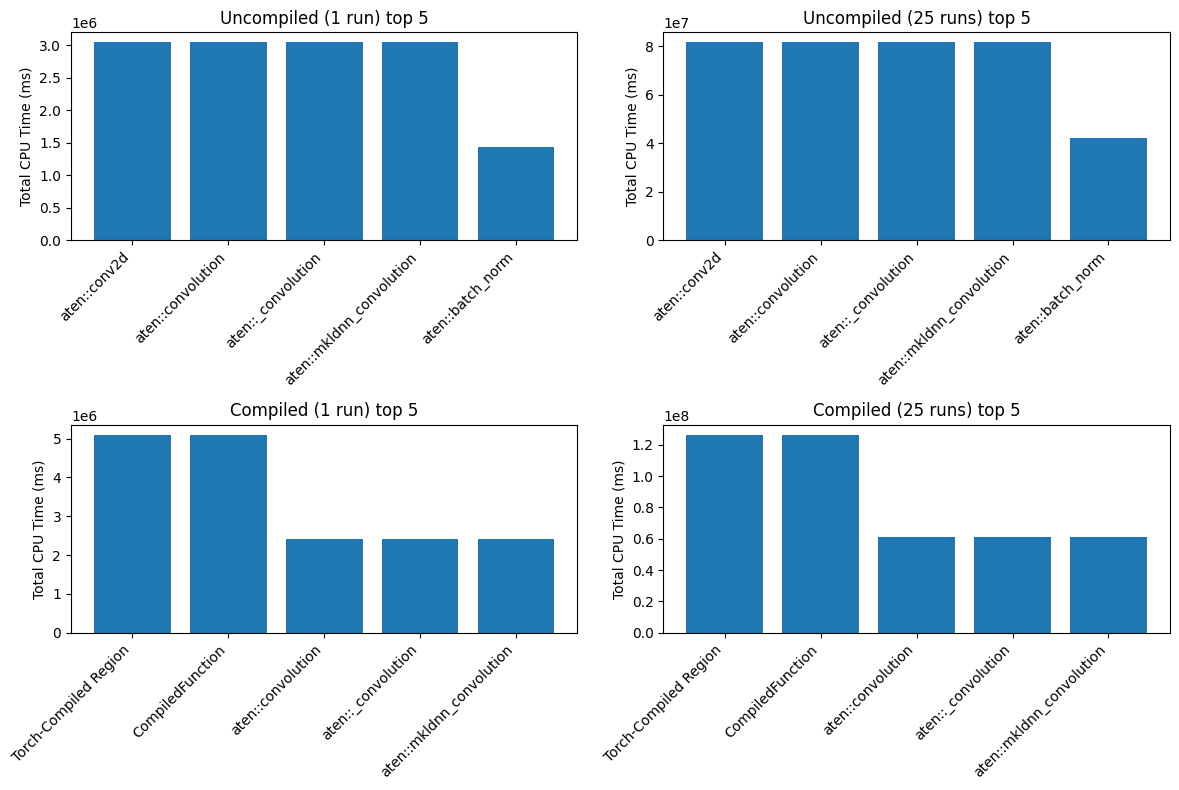

AttributeError: 'FunctionEventAvg' object has no attribute 'cuda_time_total'

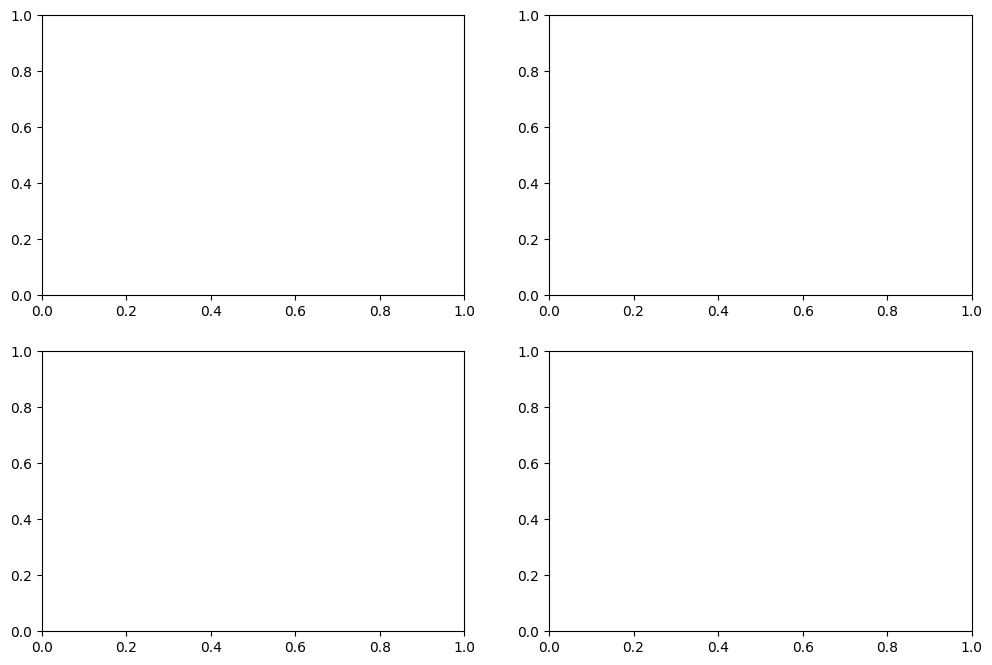

In [ ]:
import matplotlib.pyplot as plt

def get_top5(prof):
    events = prof.key_averages()
    return sorted(events, key=lambda e: e.cpu_time_total, reverse=True)[:5]

def plot_top5(ax, events, title):
    x = range(len(events))
    y = [e.cpu_time_total for e in events]
    labels = [e.key for e in events]
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel("Total CPU Time (ms)")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_top5(axes[0,0], get_top5(p_u_1), "Uncompiled (1 run) top 5")
plot_top5(axes[0,1], get_top5(p_u_25), "Uncompiled (25 runs) top 5")
plot_top5(axes[1,0], get_top5(p_c_1), "Compiled (1 run) top 5")
plot_top5(axes[1,1], get_top5(p_c_25), "Compiled (25 runs) top 5")

plt.tight_layout()
plt.show()





def get_top5_cuda(prof):
    events = prof.key_averages()
    return sorted(events, key=lambda e: e.cuda_time_total, reverse=True)[:5]

def plot_top5(ax, events, title):
    x = range(len(events))
    # cuda_time_total is in microseconds, converting to milliseconds
    y = [e.cuda_time_total / 1000.0 for e in events]
    labels = [e.key for e in events]
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel("Total CUDA Time (ms)")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_top5(axes[0][0], get_top5_cuda(p_gpu_uncompiled_1),  "Uncompiled (1 run) Top 5")
plot_top5(axes[0][1], get_top5_cuda(p_gpu_uncompiled_25), "Uncompiled (25 runs) Top 5")
plot_top5(axes[1][0], get_top5_cuda(p_gpu_compiled_1),    "Compiled (1 run) Top 5")
plot_top5(axes[1][1], get_top5_cuda(p_gpu_compiled_25),   "Compiled (25 runs) Top 5")

plt.tight_layout()
plt.show()



/tmp/ipykernel_3290046/3947032313.py:32: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  sorted_events = sorted(events, key=lambda e: e.cuda_time, reverse=True)
/tmp/ipykernel_3290046/3947032313.py:38: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  y = [evt.cuda_time / 1000.0 for evt in events]
/tmp/ipykernel_3290046/3947032313.py:32: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  sorted_events = sorted(events, key=lambda e: e.cuda_time, reverse=True)
/tmp/ipykernel_3290046/3947032313.py:38: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  y = [evt.cuda_time / 1000.0 for evt in events]
/tmp/ipykernel_3290046/3947032313.py:32: FutureWarning: `cuda_time` is deprecated, please use `device_time` instead.
  sorted_events = sorted(events, key=lambda e: e.cuda_time, reverse=True)
/tmp/ipykernel_3290046/3947032313.py:38: FutureWarning: `cuda_time` is deprecated, please use `

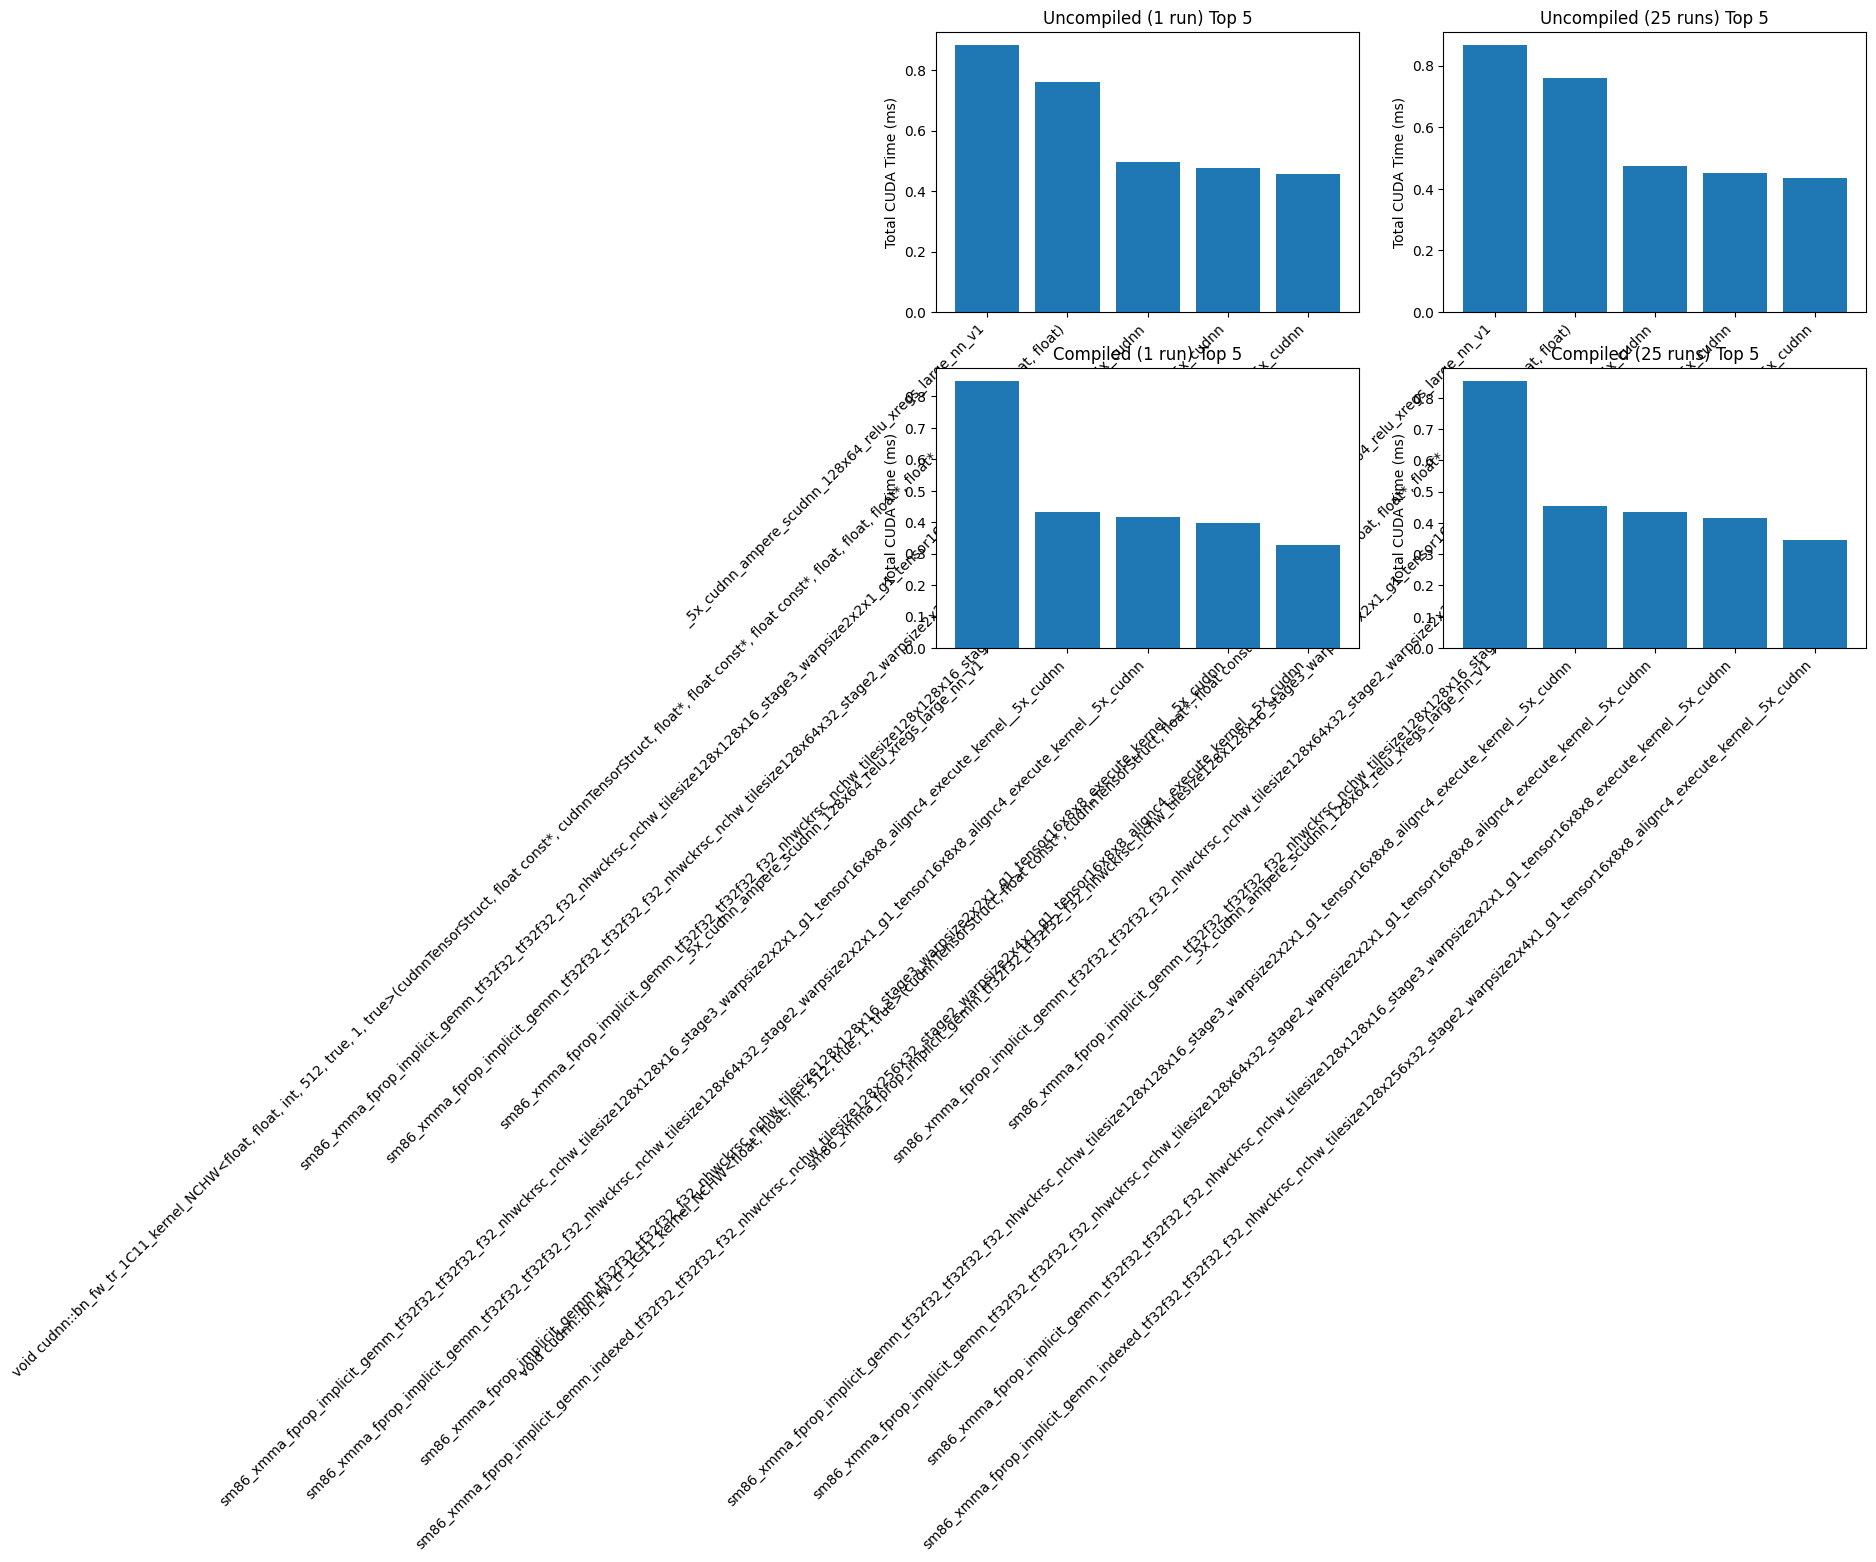

In [26]:
import torch
import torch.profiler as profiler
import matplotlib.pyplot as plt
from chop.models import get_model
from chop.dataset import get_dataset_info

device = "cuda"
cifar10_info = get_dataset_info("imagenet")
model = get_model("resnet18", pretrained=True, dataset_info=cifar10_info).to(device)
opt_model = torch.compile(model).to(device)
data = torch.randn(64, 3, 224, 224).to(device)

def run_and_profile(m, d, runs):
    # Warm-up
    for _ in range(3):
        _ = m(d)
    # Actual profiling
    with profiler.profile(activities=[profiler.ProfilerActivity.CUDA]) as prof:
        for _ in range(runs):
            _ = m(d)
    return prof

# Gather GPU profiles
p_gpu_uncompiled_1 = run_and_profile(model, data, 1)
p_gpu_uncompiled_25 = run_and_profile(model, data, 25)
p_gpu_compiled_1 = run_and_profile(opt_model, data, 1)
p_gpu_compiled_25 = run_and_profile(opt_model, data, 25)

def get_top5_cuda(prof):
    events = prof.key_averages()
    # Sort by total CUDA time (in microseconds)
    sorted_events = sorted(events, key=lambda e: e.cuda_time, reverse=True)
    return sorted_events[:5]

def plot_top5(ax, events, title):
    x = range(len(events))
    # cuda_time is in microseconds, so convert to ms
    y = [evt.cuda_time / 1000.0 for evt in events]
    labels = [evt.key for evt in events]
    ax.bar(x, y)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    ax.set_title(title)
    ax.set_ylabel("Total CUDA Time (ms)")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

plot_top5(axes[0][0], get_top5_cuda(p_gpu_uncompiled_1),  "Uncompiled (1 run) Top 5")
plot_top5(axes[0][1], get_top5_cuda(p_gpu_uncompiled_25), "Uncompiled (25 runs) Top 5")
plot_top5(axes[1][0], get_top5_cuda(p_gpu_compiled_1),    "Compiled (1 run) Top 5")
plot_top5(axes[1][1], get_top5_cuda(p_gpu_compiled_25),   "Compiled (25 runs) Top 5")

plt.tight_layout()
plt.show()


## Kernel Fusion

Fused kernels are advantageous as they can reduce both the number of memory accesses and number of kernel launches. This can be particularly useful when you have a lot of small operations that can be fused together.

### A simple example

Assuming we have a simple module consiting of a linear layer and a relu activation function,

```python
import torch.nn as nn

class MyLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(MyLayer, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        y1 = self.linear(x)
        y2 = self.relu(y1)
        return y2
```

Note that both the linear layer (`torch.nn.functional.linear`) and ReLU layer (`torch.nn.functional.relu`) are built-in PyTorch operations. Here is what happens when this module runs on a GPU:

- The kernel for the linear layer is launched on the GPU: 
  - Tiles of the input tensor `x` and weights `W` are **loaded from GPU's global memory** to shared memory
  - Matrix multiplication runs with the `x` and `W` tiles, and the partial results are accumulated in registers until the entire output tile is completed.
  - The output tile is **written back** to the global memory (`y1`).
- Similarly, the kernel for the ReLU layer is then launched on the GPU:
  - Tiles of `y1` is **loaded from the global memory**.
  - ReLU is performed on `y1` tiles, 
  - The results are **written back to the global memory**.

Everytime we call a kernel, we have to load the data from the global memory, and later write the results back. Because of the limited bandwidth of the global memory, one way to improve the performance is to reduce the number of memory accesses. This is where fused kernels come in. A fused kernel of linear and relu works like this:

- When the kernel for the fused operation is launched on the GPU:
  - Tiles of the input tensor `x` and weights `W` are **loaded from GPU's global memory** to shared memory
  - The matrix multiplications runs on with `x` and `W` tiles, and the partial results are accumulated in registers until the entire output tile is completed.
  - *ReLU is performed on the output tile*
  - The results are **written back to the global memory**.

Fusing these two kernels saves the one read and one write between the GPU's (relatively) slow global memory and fast cache memory, especially considering that ReLU (relu(x)=max(0, x)) is a memory-bouded operation. 


### SDPA example
The following example demonstrates a fused kernel to optimize the performance of the scaled dot product attention (SDPA). SDPA denotes the attention operations in Transformer, consisting of two GEMMs with a softmax operation in between. PyTorch 2.0+ offers a fused kernel for SDPA.

Here we show the naive implementation of SDPA and also call the fused kernel for comparison.

In [5]:
import math
import torch
import torch.nn.functional as F


class ScaledDotProductAttention(torch.nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()

    def forward(self, query, key, value):
        scale_factor = 1 / math.sqrt(query.size(-1))
        score = query @ key.transpose(-2, -1) * scale_factor
        attn = F.softmax(score, -1)
        context = attn @ value
        return context


class ScaledDotProductAttentionFused(torch.nn.Module):
    def forward(self, query, key, value):
        return F.scaled_dot_product_attention(query, key, value)

The first implementation makes use of a number of functions to compute the scaled dot product attention. The second implementation uses a fused kernel provided by Pytorch to compute the scaled dot product attention.

Now we can do a very simple test to check their functional equivalence.

In [ ]:
device = "cpu"
query = torch.ones(32, 8, 128, 64, dtype=torch.float16, device=device)
key = torch.ones(32, 8, 128, 64, dtype=torch.float16, device=device)
value = torch.ones(32, 8, 128, 64, dtype=torch.float16, device=device)

y1 = ScaledDotProductAttention()(query, key, value)
y2 = ScaledDotProductAttentionFused()(query, key, value)
print(y1[0, 0, 0, 0], y2[0, 0, 0, 0])

tensor(1., dtype=torch.float16) tensor(1., dtype=torch.float16)


The method behind fused SPDA is detailed in the [FlashAttention paper](https://arxiv.org/abs/2205.14135). FlashAttention loads Q, K, and V tiles from global memory, and computes the attention scores and the weighted sum of values in a single kernel. Note that the softmax is a row reduction operation, thus FlashAttention use a trick called "online-softmax", which records row max and row sum of partial results and scales the partial results before accumulation. Online-softmax allows the fusion of the GEMM-softmax-GEMM operation into a single kernel, saving the memory bandwidth and improving the performance losslessly. FlashAttention also optimizes the backward propagation computation of the attention layer. If you are interested in the details, you can check the paper series of FlashAttention, and [Triton implementation of FlashAttention](https://triton-lang.org/main/getting-started/tutorials/06-fused-attention.html) (Triton provides a Python-based programming environment for writing DNN compute kernels on GPU hardware without having to write CUDA code).

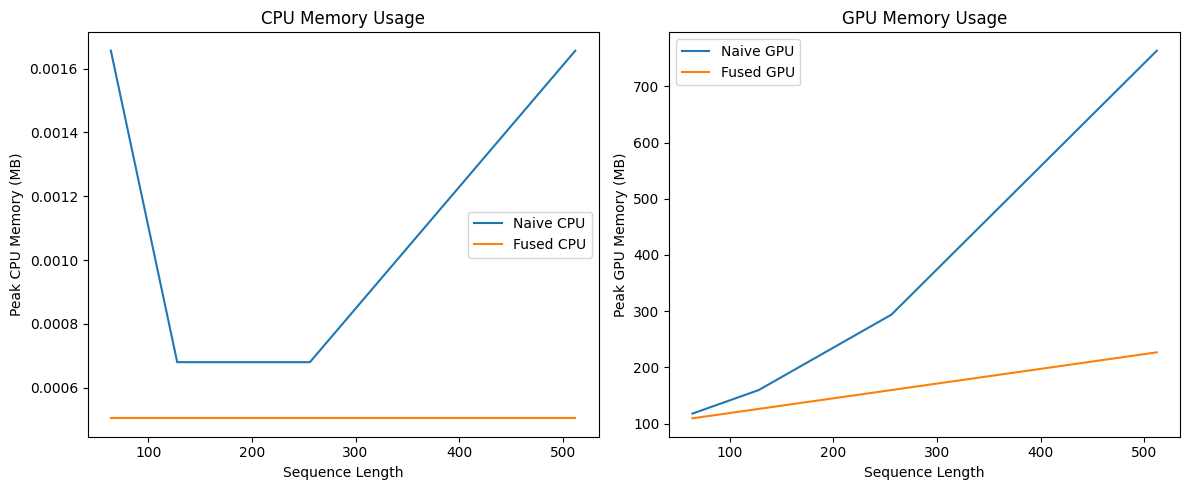

CPU output difference (L2 norm):  8.773631270742044e-05
GPU output difference (L2 norm):  0.00019839673768728971


In [9]:
import math
import matplotlib.pyplot as plt
import tracemalloc
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------------------------
# SDPA Modules
# ---------------------------
class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, query, key, value):
        scale_factor = 1 / math.sqrt(query.size(-1))
        score = torch.matmul(query, key.transpose(-2, -1))  # QK^T
        score = score * scale_factor                        # scale
        attn = F.softmax(score, dim=-1)                     # softmax
        context = torch.matmul(attn, value)                 # (attn * V)
        return context

class ScaledDotProductAttentionFused(nn.Module):
    def forward(self, query, key, value):
        return F.scaled_dot_product_attention(query, key, value)

# ---------------------------
# Peak memory measurement
# ---------------------------

def measure_peak_memory_cpu(fn, warmup=10, steps=20):
    """
    Measures peak CPU memory usage of a function by running it multiple times.
    Uses tracemalloc for measuring memory usage in Python.
    
    - warmup: number of warmup calls (ignored in final measurement).
    - steps: number of measured calls.
    Returns peak memory usage in MB (float).
    """
    # Warmup
    for _ in range(warmup):
        fn()

    tracemalloc.start()
    for _ in range(steps):
        fn()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    # peak is in bytes; convert to MB
    return peak / 1e6

def measure_peak_memory_gpu(fn, warmup=10, steps=20, device="cuda"):
    """
    Measures peak GPU memory usage of a function by running it multiple times.
    - warmup: number of warmup calls (ignored in final measurement).
    - steps: number of measured calls.
    Returns peak memory usage in MB (float).
    """
    # Warmup
    for _ in range(warmup):
        fn()

    torch.cuda.reset_peak_memory_stats(device=device)
    for _ in range(steps):
        fn()

    peak_mem_bytes = torch.cuda.max_memory_allocated(device=device)
    return peak_mem_bytes / 1e6

# ---------------------------
# Main script
# ---------------------------
if __name__ == "__main__":
    # Instantiate both models for CPU and GPU
    sdpa_naive_cpu = ScaledDotProductAttention().to("cpu")
    sdpa_fused_cpu = ScaledDotProductAttentionFused().to("cpu")

    sdpa_naive_gpu = ScaledDotProductAttention().cuda()
    sdpa_fused_gpu = ScaledDotProductAttentionFused().cuda()

    # Vary the sequence length
    seq_lens = [64, 128, 256, 512]

    # Collect results
    mem_naive_cpu = []
    mem_fused_cpu = []
    mem_naive_gpu = []
    mem_fused_gpu = []

    for seq_len in seq_lens:
        # Prepare CPU inputs
        query_cpu = torch.randn(32, 8, seq_len, 64, dtype=torch.float32, device="cpu")
        key_cpu   = torch.randn(32, 8, seq_len, 64, dtype=torch.float32, device="cpu")
        value_cpu = torch.randn(32, 8, seq_len, 64, dtype=torch.float32, device="cpu")

        # Prepare GPU inputs
        query_gpu = query_cpu.cuda()
        key_gpu   = key_cpu.cuda()
        value_gpu = value_cpu.cuda()

        # Define callables for CPU
        def run_naive_cpu():
            return sdpa_naive_cpu(query_cpu, key_cpu, value_cpu)

        def run_fused_cpu():
            return sdpa_fused_cpu(query_cpu, key_cpu, value_cpu)

        # Define callables for GPU
        def run_naive_gpu():
            return sdpa_naive_gpu(query_gpu, key_gpu, value_gpu)

        def run_fused_gpu():
            return sdpa_fused_gpu(query_gpu, key_gpu, value_gpu)

        # Measure CPU memory usage
        mem_naive_cpu.append(measure_peak_memory_cpu(run_naive_cpu))
        mem_fused_cpu.append(measure_peak_memory_cpu(run_fused_cpu))

        # Measure GPU memory usage
        mem_naive_gpu.append(measure_peak_memory_gpu(run_naive_gpu, device="cuda"))
        mem_fused_gpu.append(measure_peak_memory_gpu(run_fused_gpu, device="cuda"))

    # ---------------------------
    # Plot: Memory usage (CPU & GPU)
    # ---------------------------
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Left subplot -> CPU memory usage
    axs[0].plot(seq_lens, mem_naive_cpu, label="Naive CPU")
    axs[0].plot(seq_lens, mem_fused_cpu, label="Fused CPU")
    axs[0].set_xlabel("Sequence Length")
    axs[0].set_ylabel("Peak CPU Memory (MB)")
    axs[0].set_title("CPU Memory Usage")
    axs[0].legend()

    # Right subplot -> GPU memory usage
    axs[1].plot(seq_lens, mem_naive_gpu, label="Naive GPU")
    axs[1].plot(seq_lens, mem_fused_gpu, label="Fused GPU")
    axs[1].set_xlabel("Sequence Length")
    axs[1].set_ylabel("Peak GPU Memory (MB)")
    axs[1].set_title("GPU Memory Usage")
    axs[1].legend()

    plt.tight_layout()
    plt.show()

    # ---------------------------
    # Quick correctness check
    # ---------------------------
    # We'll just check the final seq_len for functional equivalence on CPU and GPU
    query_cpu = torch.randn(32, 8, seq_lens[-1], 64, dtype=torch.float32, device="cpu")
    key_cpu   = torch.randn(32, 8, seq_lens[-1], 64, dtype=torch.float32, device="cpu")
    value_cpu = torch.randn(32, 8, seq_lens[-1], 64, dtype=torch.float32, device="cpu")

    y1_cpu = sdpa_naive_cpu(query_cpu, key_cpu, value_cpu)
    y2_cpu = sdpa_fused_cpu(query_cpu, key_cpu, value_cpu)
    print("CPU output difference (L2 norm): ", (y1_cpu - y2_cpu).norm().item())

    query_gpu = query_cpu.cuda()
    key_gpu   = key_cpu.cuda()
    value_gpu = value_cpu.cuda()

    y1_gpu = sdpa_naive_gpu(query_gpu, key_gpu, value_gpu)
    y2_gpu = sdpa_fused_gpu(query_gpu, key_gpu, value_gpu)
    print("GPU output difference (L2 norm): ", (y1_gpu - y2_gpu).norm().item())


## Custom Kernels

Custom kernels are a powerful way to optimize the performance of your code. 

When you run a PyTorch built-in function, e.g., `torch.matmul`, PyTorch will call the corresponding kernel function wrapped in its backend ATen to execute the operation. These built-in kernels may come from different libraries, such as Intel MKL, NVIDIA cuBLAS, or PyTorch's own implementation. PyTorch provides a lot of built-in kernels for different operations. However, sometimes you may want to write your own custom kernel to support a specific operation that PyTorch does not natively provide.

### Quantization and Dequantization
In the following, we show *a custom kernel for dequantization*. Dequantization is the process of converting quantized values back to floating-point values. 

- Here is an example of 4-bit fixed-point numbers with radix point placed at the most significant bit (0b.0000). Quantizing an FP32 number to 4-bit fixed-point means finding the closest 4-bit fixed-point number. This process introduces quantization error, e.g., 0.0621687 will be rounded to 0.0625 (with an error of 0.000103313), but a previously 32-bit number can now be represented with only 4 bits, and potentially accelerate the computation if the hardware supports 4-bit fixed-point operations.

  ```bash
  | FP32       | 4-bit fixed-point        |
  | ---------- | ------------------------ |
  | 0.0        | 0.0    (0b0000)          |
  | 0.0625     | 0.0625 (0b0001)          |
  | 0.125      | 0.125  (0b0010)          |
  | 0.1875     | 0.1875 (0b0011)          |
  | 0.25       | 0.25   (0b0100)          |
  | ...        | ...                      |
  ```

- Dequantization is the reverse process of quantization. It converts the quantized values back to floating-point values (without fixing the quantization error).

GPU is still a common choice of running DNN workloads. DNN Quantization methods for GPUs can be generally categorized into two types:
(a) Weight-only quantization, (b) Weight-and-activation quantization. The kernel in this tutorial is for the former, which only quantizes weights to save GPU memory.

### MXINT Format

MXINT is a number format of vectors between floating-point and fixed-point, proposed by Microsoft ([ref](https://www.microsoft.com/en-us/research/publication/with-shared-microexponents-a-little-shifting-goes-a-long-way/)) and standardized by the industry for AI facility ([ref](https://www.opencompute.org/documents/ocp-microscaling-formats-mx-v1-0-spec-final-pdf)).

MXINT takes the following form with `group_size` as the number of mantissas in a group sharing the same 8-bit exponent:

```text
Exp |- Mantissa 1
    |- Mantissa 2
    |- ...
    |- Mantissa group_size
```
The mantissa in MXINT is signed fixed-point with the radix point placed after the 2nd leftmost bit, and exp is an 8-bit unsigned integer biased by 127.

```text
Exp: eeee_eeee
Mantissa (8-bit in this example): si.ii_iiii
```

For example, an example of an MXINT4 (4 denotes the mantissa bitwidth) vector with `group_size=4` looks like this:

```text
EXP = 0b0111_1111
MANTISSA = [0b11.00]
           [0b01.00]
           [0b00.10]
           [0b00.01]    
``` 

The four mantissas share the same exponent.

To dequantize this MXINT4 vector, we scale each fixed-point value by the shared exponent:

- The decimal value of EXP is E = 2^(EXP-127) = 2^(127-127) = 1
- Then we scale each signed fixed-point value by E, i.e., `E .* MANTISSA`
```text
                         [0b11.00]        [-1.0 ]    [-1.0]
    E .* MANTISSA = 1 .* [0b01.00] = 1 .* [ 1.0 ]  = [ 1.0]
                         [0b00.10]        [ 0.5 ]    [ 0.5]
                         [0b00.11]        [ 0.25]    [ 0.25]
```

The effective bitwidth of this MXINT4 vector is (4 + 8/4) = 6 bits. If we increase the group size to 32, the effective bitwidth will be (4 + 8 / 32) = 4.25 bits. Compared to 4-bit fixed-point number that only represents 16 values, MXINT4 with group_size = 32 can represent 2^8 * 16 = 4096 values, reducing the quantization error.

❓ **Question**: How does MXINT8 benefit custom hardware if both the activation and weights in a linear layer are quantized to MXINT8?

Now We show a custom kernel for dequantizing MXINT8 numbers, and show how it saves GPU memory with minimal loss of model performance.


### Custom Kernel for MXINT8 Dequantization.

#### Preamble
**Why dequantization kernel?** 

We target saving GPU memory by quantizing weights to approximated 8-bit numbers. This means model weights are stored in the form of MXINT8 in GPU global memory. When running a specific layer, the GPU loads the MXINT8 weights, dequantizes them to high-precision (BFloat16 this in kernel) and writes back for the following computation. Once computation of this layer is done, the dequantized weights are discarded. This saves GPU memory by storing weights in a more compact form.


**The following tutorial is more involved**
- CUDA-capable GPU is required.
- If developing on your own Windows laptop, WSL2 is highly recommended.
- The dev env needs setup with PyTorch, CUDA, and CMake.
- The kernel requires basic knowledge of C++, CUDA programming and CUTLASS CUTE.
  - CUTLASS is a CUDA template library for GEMM. CUTE is a part of CUTLASS for data/thread layout transformation.
  - CUTLASS repo: https://github.com/NVIDIA/cutlass
  - CUTE-related docs: https://github.com/NVIDIA/cutlass/tree/main/media/docs/cute

**MASE-CUDA** 
- The source codes of MXINT8 dequantization kernel can be found in [MASE-CUDA](https://github.com/DeepWok/mase-cuda).
- To setup the dev environment for custom kernels, please refer to the [README.md](https://github.com/DeepWok/mase-cuda/tree/master) and [this file](https://github.com/DeepWok/mase-cuda/blob/master/docs/beginner.md). This dev env is for building the kernel and Python package wheel. Once the wheel is built, you may install it in the mase environment and use it to quantize models.

#### MXINT8 Dequantization Kernel

The following kernels dequantize MXINT8 data to [BFloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format).

##### CPU kernel
Usually before implementing CUDA kernels, we need to check the correctness of our understanding. This can be done by writing a CPU or Python version of the algorithm, which is easy to debug. [`mase_cuda::mxint8::dequantize::dequantize1d_host`](https://github.com/DeepWok/mase-cuda/blob/master/src/csrc/mxint/dequantize.cuh) is the C++ version of the dequantization algorithm, and [`mase_cuda.mxint8.dequantize.dequantize1d_simulated`](https://github.com/DeepWok/mase-cuda/blob/master/src/mase_cuda/mxint8/dequantize.py) is the PyTorch-simulated version of the algorithm. Here is the core part of the C++ version:

```cpp
    for (int i = 0; i < M; ++i) {
        auto sign = static_cast<uint16_t>(hX[i] & 0x80) << 8;
        auto exp = static_cast<uint16_t>(hScales[i / group_size]) << 7;
        auto mantissa_abs = abs(hX[i]);
        auto frac = static_cast<uint16_t>((mantissa_abs & 0x3F) << 1);
        auto out = cutlass::bfloat16_t::bitcast(sign | exp | frac);
        auto dont_need_abs = bool(mantissa_abs & 0x40);
        auto bias = cutlass::bfloat16_t::bitcast(sign | exp | uint16_t(0));
        y[i] = dont_need_abs ? out : out - bias;
    }
```

For each mantissa element, the loop 
- splits the sign bit from the mantissa, upcasts it to 16-bit and shifts it to the correct position.
- upcasts the scale to 16-bit and shifts it to the correct position.
- converts the int8 mantissa to BFloat16's fraction part. 

❓ **Question**: What is the purpose of the `dont_need_abs` variable and the `bias` variable? Note that unlike IEEE Floating-Point, MXINT has no implicit leading bit for the mantissa.

##### GPU kernel
The CUDA kernel codes can be found at [`mase_cuda::mxint8::dequantize:dequantize1d_device`](https://github.com/DeepWok/mase-cuda/blob/master/src/csrc/mxint/dequantize.cuh). This kernel treats 1D data as a matrix of shape `[num_groups, group_size]` using `group_tiler`. Then it loads tiles of MXINT8 data from global memory to shared memory, dequantizes them using the algorithm above, and write the dequantized BFloat16 number back to global memory. This kernel leverages CUTE for partitioning data for copy, and partitioning threads in a threadblock for computation. Besides, it creates predication masks to avoid out-of-bound accesses.

❓ **Question (Challenging)**: How does `cta_tiler` partition the data for copy? You may find the documentation of `local_tile` in CUTE helpful ([ref](https://github.com/NVIDIA/cutlass/blob/main/media/docs/cute/02_layout_algebra.md))

❓ **Question (Challenging)**: How does `layout_sX` partition the threads in a threadblock for computation? You may find the documentation of `local_partition` in CUTE helpful ([ref](https://github.com/NVIDIA/cutlass/blob/main/media/docs/cute/02_layout_algebra.md))

---

📝 **C++/CUDA Build**: The following tutorial requires setting up a C++ & CUDA dev env. **If you do not have a CUDA-enabled machine, or you find it difficult to set up such an env, you may use Colab instead: Open [lab4_software_custom_kernel_colab_minimal.ipynb](./lab4_software_custom_kernel_colab_minimal.ipynb) in your Colab and run it there.**

##### Testing the kernel

After implementing the CUDA kernel, we can compare its output to the CPU version to check the correctness. A simple test to check the correctness of the CUDA kernel can be found [here](https://github.com/DeepWok/mase-cuda/blob/master/test/cu/mxint/dequantize/test_mxint8_dequantize1d.cu). We first generate random MXINT8 data, dequantize them using the CPU version, and then compare the results with the GPU version.

You may run the following just command to build and run the test executable. Before that, you may need to change the `TORCH_CUDA_ARCH_LIST` variable in the [justfile](https://github.com/DeepWok/mase-cuda/blob/master/justfile) to match your GPU's [compute capability](https://developer.nvidia.com/cuda-gpus).
```bash
# build the test executable
$ just --set CU_BUILD_TARGETS test_mxint8_dequantize1d build-cu-test
# run the test executable
$ ./build/test/cu/mxint/dequantize/test_mxint8_dequantize1d 
Usage: ./build/test/cu/mxint/dequantize/test_mxint8_dequantize1d [m] [group_size] [is_random]
m=4096, group_size=128, num_groups=32, is_random=0
PASSED
# or you can specify the arguments
$ ./build/test/cu/mxint/dequantize/test_mxint8_dequantize1d 2048 32 1
Usage: ./build/test/cu/mxint/dequantize/test_mxint8_dequantize1d [m] [group_size] [is_random]
m=2048, group_size=32, num_groups=64, is_random=1
PASSED
```

##### Binding the kernel to PyTorch 

Many DeepLearning packages run on Python, and PyTorch is one of the most popular ones. To use the CUDA kernel in PyTorch, we need to 
- Wrap the kernels with LibTorch API in C++. The wrapper function `mase_cuda::mxint8::dequantize::dequantize1d` can be found [here](https://github.com/DeepWok/mase-cuda/blob/master/src/csrc/mxint/dequantize.cuh). This wrapper takes PyTorch Tensors, and calls the CPU kernel or the CUDA kernel based on the device type of the input tensors, and returns the dequantized BFloat16 Tensors.
- Build the wrapper as an extension module (named `mase_cuda_ext` in this case) of `mase_cuda`. These steps uses PyBind11 and PyTorch C++ Extension. Here are the related files:
  - [bind.cu](https://github.com/DeepWok/mase-cuda/blob/master/src/csrc/bind.cu)
  - [setup.py](https://github.com/DeepWok/mase-cuda/blob/master/setup.py)
- Build `mase_cuda` package! You can build the package by running the following command:
  ```bash
  # the wheel file will be generated in the dist folder
  $ just-build-py
  # install the wheel file
  $ pip install dist/mase_cuda-0.0.1-cp311-cp311-linux_x86_64.whl
  ```

#### Playing with the kernel

The dequantization is now available in Python package `mase_cuda_ext`, and the main package `mase_cuda` has a Python wrapper over it.

##### Latency profiling: GPU vs CPU

Function [`test_ext_dequantize1d_latency`](https://github.com/DeepWok/mase-cuda/blob/master/test/py/mxint8/dequantize/test_dequantize1d.py) compares the latency of the CPU version and the GPU version of the dequantization kernel. This test case can be triggered by running the following command:

📝 **Note** Remember to reduce the element number `num_elements` in `test_ext_dequantize1d_latency` before running it as too many elements may run out of CPU/GPU memory!!!

```bash
$ just --set PYTEST_PATTERN test_ext_dequantize1d_latency test-py-pattern 
```

Here is an example output of the test case:

```text
test/py/mxint8/dequantize/test_dequantize1d.py::test_ext_dequantize1d_latency
----------------------------------------------------------------------------- live log call ------------------------------------------------------------------------------
INFO     test_dequantize1d:test_dequantize1d.py:203
+-----------+------------+------------------------+------------------------+---------------------+
|     m     | group_size |      latency_cpu       |      latency_gpu       |     GPU speedup     |
+-----------+------------+------------------------+------------------------+---------------------+
|   1024    |     8      | 9.584426879882813e-06  | 3.673119996674359e-05  | 0.2609342163762836  |
|   1024    |     16     |  4.9591064453125e-06   | 1.1745599983260035e-05 | 0.4222097170327847  |
|   1024    |     32     | 3.993511199951172e-06  | 1.1219199933111667e-05 | 0.3559532964703628  |
|   1024    |     64     | 3.826618194580078e-06  | 1.118720006197691e-05  | 0.3420532549146055  |
|   1024    |    128     | 3.933906555175781e-06  | 1.1347199836745858e-05 | 0.34668522734891255 |
|   1024    |    256     | 3.921985626220703e-06  | 1.0571199934929609e-05 | 0.3710066643675507  |
|   1024    |    512     | 3.7789344787597655e-06 | 1.0598399955779315e-05 | 0.35655707413637566 |
|  2097152  |     8      |  0.00988675355911255   | 1.6137600084766744e-05 |  612.653276024931   |
|  2097152  |     16     |  0.00951402187347412   | 1.6275200061500074e-05 |  584.571731070765   |
...
| 234881024 |     8      |   1.0949357390403747   | 0.0018697983980178834  |  585.5902648120154  |
| 234881024 |     16     |   1.0813238978385926   | 0.0017637632012367248  |  613.0777062818775  |
| 234881024 |     32     |   1.0706217408180236   | 0.0017168064057826995  |  623.6123870529959  |
| 234881024 |     64     |   1.0728538513183594   | 0.0017273023962974547  |  621.1152451464588  |
| 234881024 |    128     |   1.062897527217865    | 0.0017135215997695922  |  620.3000460343113  |
| 234881024 |    256     |   1.0750348925590516   | 0.0017249839961528779  |  623.2144152969729  |
| 234881024 |    512     |   1.0646217107772826   | 0.0011905567944049836  |  894.2216917164034  |
+-----------+------------+------------------------+------------------------+---------------------+
PASSED                                                                                                                                                             [100%]
```

GPU is much faster than CPU if the data size is large enough.


##### Saved GPU memory

Let's use the dequantization kernel in a real model. `mase_cuda` has a custom layer `mase_cuda.mxint8.linear.QLinearPacked` for demostration (source code [here](https://github.com/DeepWok/mase-cuda/blob/master/src/mase_cuda/mxint8/linear.py)).

We can compress the linear layers in a model with `QLinearPacked` and inspect the GPU memory usage. Install the built mase-cuda wheel in mase env (**not the dev env for kernel building**) and run the following codes using Python in mase env .


- First let's just run a simple sentiment analysis model in FP32. **Please copy the code below to a new Python file and run it instead of running it in the notebook.** This example runs a Deberta model which classifies the emotion of a sentence into one of the 6 categories: `anger`, `fear`, `joy`, `love`, `sadness`, `surprise`.

    ```python
    import torch
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    
    model_name = "AnkitAI/deberta-xlarge-base-emotions-classifier"
    # if you meet OOM error, try this smaller model, but the quantization effect may not be obvious later
    # model_name = "AnkitAI/deberta-v3-small-base-emotions-classifier" 
    model = AutoModelForSequenceClassification.from_pretrained(model_name).cuda().eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    label2emotion = {idx: emotion for emotion, idx in model.config.label2id.items()}
    
    
    # Example usage
    @torch.no_grad()
    def predict_emotion(model, tokenizer, text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.cuda() for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = logits.argmax(dim=1)
        predictions = label2emotion[predictions.item()]
        top3_values, top3_indices = torch.topk(logits, 3)
        top3_values = top3_values.cpu().tolist()
        top3_indices = top3_indices.cpu().tolist()
        return predictions, (top3_values, top3_indices)
    
    
    text = "I'm so happy with the results!"
    emotion, top3 = predict_emotion(model, tokenizer, text)
    
    print("Index to Emotion Mapping:", label2emotion)
    print("Input text:", text)
    print("Detected Emotion:", emotion)
    print(f"top3 logits: {top3[0]}, top3 indices: {top3[1]}")
    ```

    This code will output the detected emotion of the input text and the top 3 logits and their indices.
  
  
- Then let's compress the model with MXINT8 and inspect the GPU memory usage. **Please copy the code below to a new Python file and run it instead of running it in the notebook.**

    ```python
    import torch
    from transformers import AutoModelForSequenceClassification, AutoTokenizer
    
    from mase_cuda.mxint8.linear import QLinearPacked
    
    init_memory = torch.cuda.memory_allocated()  # in bytes
    model_name = "AnkitAI/deberta-xlarge-base-emotions-classifier"
    model = AutoModelForSequenceClassification.from_pretrained(model_name, torch_dtype=torch.float32).cuda().eval()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    label2emotion = {idx: emotion for emotion, idx in model.config.label2id.items()}
    
    mxint8_group_size = 32
    assert model.config.hidden_size % mxint8_group_size == 0
    assert model.config.intermediate_size % mxint8_group_size == 0
    
    text = "I'm so happy with the results!"
    
    
    # Example usage
    @torch.no_grad()
    def predict_emotion(model, tokenizer, text):
        inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
        inputs = {k: v.cuda() for k, v in inputs.items()}
        outputs = model(**inputs)
        logits = outputs.logits
        predictions = logits.argmax(dim=1)
        predictions = label2emotion[predictions.item()]
        top3_values, top3_indices = torch.topk(logits, 3)
        top3_values = top3_values.cpu().tolist()
        top3_indices = top3_indices.cpu().tolist()
        return predictions, (top3_values, top3_indices)
    
    
    # check the GPU memory usage of FP32 model
    torch.cuda.reset_peak_memory_stats()
    emotion_fp32, top3_fp32 = predict_emotion(model, tokenizer, text)
    peak_memory_fp32 = torch.cuda.max_memory_allocated() - init_memory  # in bytes
    
    
    def set_layer_by_name(module: torch.nn.Module, name: str, new_layer: torch.nn.Module):
        """
        Replace a layer (`new_layer`) in a model (`module`) by its `name`.
        """
        levels = name.split(".")
        if len(levels) > 1:
            mod_ = module
            for l_idx in range(len(levels) - 1):
                if levels[l_idx].isdigit():
                    mod_ = mod_[int(levels[l_idx])]
                else:
                    mod_ = getattr(mod_, levels[l_idx])
            setattr(mod_, levels[-1], new_layer)
        else:
            setattr(module, name, new_layer)
    
    
    for layer_name, layer in model.named_modules():
        if not isinstance(layer, torch.nn.Linear):
            continue
        if "classifier" in layer_name:
            continue
        layer.cuda()
        layer_q = QLinearPacked.build_from_linear(layer, group_size=mxint8_group_size)
        set_layer_by_name(model, layer_name, layer_q)
        del layer
        torch.cuda.empty_cache()
    
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()
    emotion_mxint8, top3_mxint8 = predict_emotion(model, tokenizer, text)
    peak_memory_mxint8 = torch.cuda.max_memory_allocated() - init_memory  # in bytes
    
    print(f"FP32 model peak memory: {peak_memory_fp32/1024**2:.4f} MB")
    print(f"PF32 prediction: {emotion_fp32}")
    print(f"FP32 top3 logits: {top3_fp32[0]}, indices: {top3_fp32[1]}")
    
    print(f"MXINT8 model peak memory: {peak_memory_mxint8/1024**2:.4f} MB")
    print(f"MXINT8 prediction: {emotion_mxint8}")
    print(f"MXINT8 top3 logits: {top3_mxint8[0]}, indices: {top3_mxint8[1]}")
    ```
    
    Here is an example output of the code:
    
    ```text
    FP32 model peak memory: 2906.1997 MB
    PF32 prediction: joy
    FP32 top3 logits: [[7.345229148864746, -1.485020399093628, -1.6403968334197998]], indices: [[1, 4, 0]]
    MXINT8 model peak memory: 976.1616 MB
    MXINT8 prediction: joy
    MXINT8 top3 logits: [[7.350158214569092, -1.488326072692871, -1.6497581005096436]], indices: [[1, 4, 0]]
    ```
    
    The MXINT8 **saves GPU memory by 66.4%** without affecting the final model prediction ("joy" in this case). Besides, the output logits are very close to the FP32 model.
    
    ❓ **Question**: Why the saved GPU memory is not exactly (32 - (4+8/32))/32 = 86.7%?